# Import data / Load Dataframe from Google Cloud

In [78]:
from google.colab import auth
from google.cloud import bigquery
from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
auth.authenticate_user()
print('Authenticated')

Authenticated


In [80]:
project_id = 'cmpe255-project-419122'

!gcloud config set project 'cmpe255-project-419122'

client = bigquery.Client(project=project_id)


Updated property [core/project].


In [81]:
sql = """
SELECT
    *
FROM
    `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
ORDER BY
  Year, State, County
"""
dfquery = client.query(sql)

In [82]:
df = dfquery.to_dataframe()
df

,State,County,Year,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days,Max_AQI,90th_Percentile_AQI,Median_AQI,Days_CO,Days_NO2,Days_Ozone,Days_PM2_5,Days_PM10
0,Alabama,Baldwin,2013,273,235,38,0,0,0,0,87,54,36,0,0,200,73,0
1,Alabama,Clay,2013,118,100,18,0,0,0,0,65,52,32,0,0,0,118,0
2,Alabama,Colbert,2013,285,252,33,0,0,0,0,80,51,38,0,0,202,83,0
3,Alabama,DeKalb,2013,360,319,41,0,0,0,0,93,52,38,0,0,305,55,0
4,Alabama,Elmore,2013,244,229,15,0,0,0,0,87,48,36,0,0,244,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11171,Wyoming,Sublette,2023,211,92,113,6,0,0,0,122,84,54,0,0,209,2,0
11172,Wyoming,Sweetwater,2023,212,125,78,8,0,1,0,211,87,49,0,0,170,33,9
11173,Wyoming,Teton,2023,244,203,41,0,0,0,0,74,54,46,1,0,240,3,0
11174,Wyoming,Uinta,2023,181,181,0,0,0,0,0,32,12,6,0,0,0,0,181


# Preprocessing data

In [83]:
# AQI scale only runs from 0 to 500.
cond_1 = (df['Max_AQI'] <= 500)
cond_2 = (df['90th_Percentile_AQI'] <= 500)
cond_3 = (df['Median_AQI'] <= 500)

df = df[cond_1 & cond_2 & cond_3]
df

,State,County,Year,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days,Max_AQI,90th_Percentile_AQI,Median_AQI,Days_CO,Days_NO2,Days_Ozone,Days_PM2_5,Days_PM10
0,Alabama,Baldwin,2013,273,235,38,0,0,0,0,87,54,36,0,0,200,73,0
1,Alabama,Clay,2013,118,100,18,0,0,0,0,65,52,32,0,0,0,118,0
2,Alabama,Colbert,2013,285,252,33,0,0,0,0,80,51,38,0,0,202,83,0
3,Alabama,DeKalb,2013,360,319,41,0,0,0,0,93,52,38,0,0,305,55,0
4,Alabama,Elmore,2013,244,229,15,0,0,0,0,87,48,36,0,0,244,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11171,Wyoming,Sublette,2023,211,92,113,6,0,0,0,122,84,54,0,0,209,2,0
11172,Wyoming,Sweetwater,2023,212,125,78,8,0,1,0,211,87,49,0,0,170,33,9
11173,Wyoming,Teton,2023,244,203,41,0,0,0,0,74,54,46,1,0,240,3,0
11174,Wyoming,Uinta,2023,181,181,0,0,0,0,0,32,12,6,0,0,0,0,181


In [84]:
# Make sure all the days added up to the total AQI day
sum(df.loc[:, 'Good_Days':'Hazardous_Days'].sum(axis=1) == df['Days_with_AQI']) == len(df)

True

<Axes: xlabel='Unhealthy_Days', ylabel='Percent'>

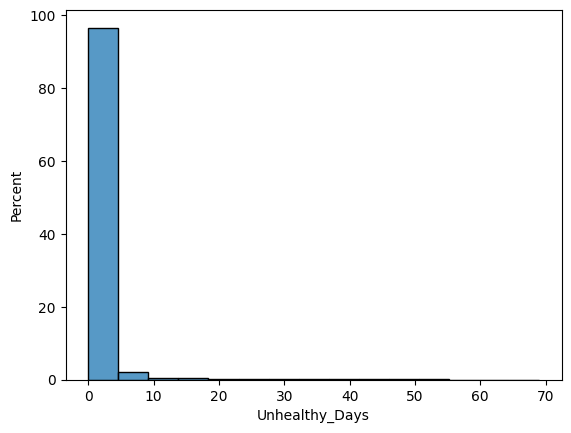

In [85]:
sns.histplot(data=df, x='Unhealthy_Days', stat='percent')

<Axes: xlabel='Very_Unhealthy_Days', ylabel='Percent'>

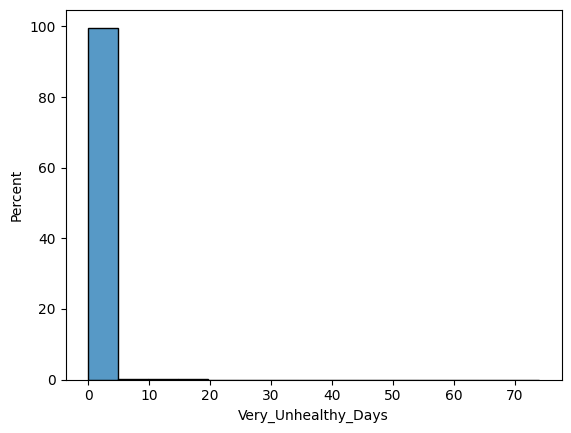

In [86]:
sns.histplot(data=df, x='Very_Unhealthy_Days', stat='percent')

<Axes: xlabel='Hazardous_Days', ylabel='Percent'>

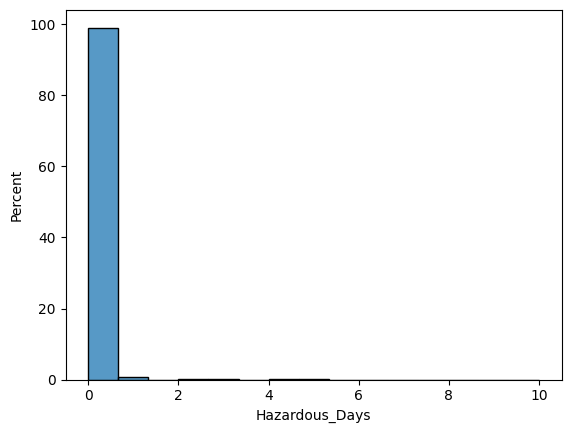

In [87]:
sns.histplot(data=df, x='Hazardous_Days', stat='percent')

We can see that the majority of rows in the dataset don't have bad days. With more than 90% of the data points being 0, we can even go as far as saying those with Unhealthy Days, Very Unhealthy Days, or Hazardous Days in general are outliers.

## Question: How many days have full 365 days of AQI?

<Axes: xlabel='Days_with_AQI', ylabel='Percent'>

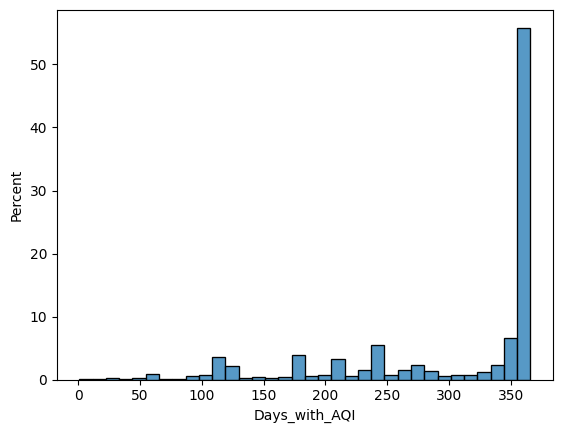

In [88]:
sns.histplot(data=df, x='Days_with_AQI', stat='percent')

With only ~55% of the data having full 365 days of AQI, we need to be careful because stastical measures like mean and median are directly affected by the amount of samples .

In other words, we can only fully trust the median AQI of 55% of the data.

Since we are not collecting the data, there is little to nothing we can do. It would be best to take the analysis with a grain of salt, keeping in mind that if something doesn't add up, it's probably due to this difference sample sizes.

# PCA

In [89]:
df_numeric = df.select_dtypes(include='number')
df_numeric = df_numeric.drop(columns='Year')
df_numeric

,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days,Max_AQI,90th_Percentile_AQI,Median_AQI,Days_CO,Days_NO2,Days_Ozone,Days_PM2_5,Days_PM10
0,273,235,38,0,0,0,0,87,54,36,0,0,200,73,0
1,118,100,18,0,0,0,0,65,52,32,0,0,0,118,0
2,285,252,33,0,0,0,0,80,51,38,0,0,202,83,0
3,360,319,41,0,0,0,0,93,52,38,0,0,305,55,0
4,244,229,15,0,0,0,0,87,48,36,0,0,244,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11171,211,92,113,6,0,0,0,122,84,54,0,0,209,2,0
11172,212,125,78,8,0,1,0,211,87,49,0,0,170,33,9
11173,244,203,41,0,0,0,0,74,54,46,1,0,240,3,0
11174,181,181,0,0,0,0,0,32,12,6,0,0,0,0,181


In [90]:
# Fit PCA and reduce dimension to 2
pca = PCA(n_components=2)
pca.fit(df_numeric)

PCA(n_components=2)

In [91]:
df_pca = pca.transform(df_numeric)
df_pca

array([[-34.79189087,  52.17839395],
       [206.72136102, 215.33054472],
       [-37.35198458,  31.71373502],
       ...,
       [-91.48410923, 122.58448483],
       [116.43728663, 209.21864836],
       [-23.58848715, 194.55548338]])

In [92]:
print("Original Shape:", df_numeric.shape)
print("Reduced Shape:", df_pca.shape)

Original Shape: (11095, 15)
Reduced Shape: (11095, 2)


In [93]:
# Insert PC1 and PC2 back into original dataframe for visulazation
df.insert(0, "PC1", df_pca[:, 0])
df.insert(0, "PC2", df_pca[:, 1])

df

,PC2,PC1,State,County,Year,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days,Max_AQI,90th_Percentile_AQI,Median_AQI,Days_CO,Days_NO2,Days_Ozone,Days_PM2_5,Days_PM10
0,52.178394,-34.791891,Alabama,Baldwin,2013,273,235,38,0,0,0,0,87,54,36,0,0,200,73,0
1,215.330545,206.721361,Alabama,Clay,2013,118,100,18,0,0,0,0,65,52,32,0,0,0,118,0
2,31.713735,-37.351985,Alabama,Colbert,2013,285,252,33,0,0,0,0,80,51,38,0,0,202,83,0
3,-45.076741,-162.823059,Alabama,DeKalb,2013,360,319,41,0,0,0,0,93,52,38,0,0,305,55,0
4,113.932185,-102.370681,Alabama,Elmore,2013,244,229,15,0,0,0,0,87,48,36,0,0,244,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11171,186.649649,-34.286807,Wyoming,Sublette,2023,211,92,113,6,0,0,0,122,84,54,0,0,209,2,0
11172,153.490258,5.744107,Wyoming,Sweetwater,2023,212,125,78,8,0,1,0,211,87,49,0,0,170,33,9
11173,122.584485,-91.484109,Wyoming,Teton,2023,244,203,41,0,0,0,0,74,54,46,1,0,240,3,0
11174,209.218648,116.437287,Wyoming,Uinta,2023,181,181,0,0,0,0,0,32,12,6,0,0,0,0,181


In order to better visualize PCA, we need some sort of categorical variables. We can divide `Good_Days` by `Days_with_AQI` and assign `Good` if the percentage is > 80% and `Bad` otherwise.

<ipython-input-94-18a590fa826c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Good_Percentage'] = df.loc[:, 'Good_Days'] / df.loc[:, 'Days_with_AQI']
<ipython-input-94-18a590fa826c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Overall_Quality'] = df['Good_Percentage'].apply(lambda x: 'Good' if x >= 0.80 else 'Bad')


<Axes: xlabel='PC1', ylabel='PC2'>

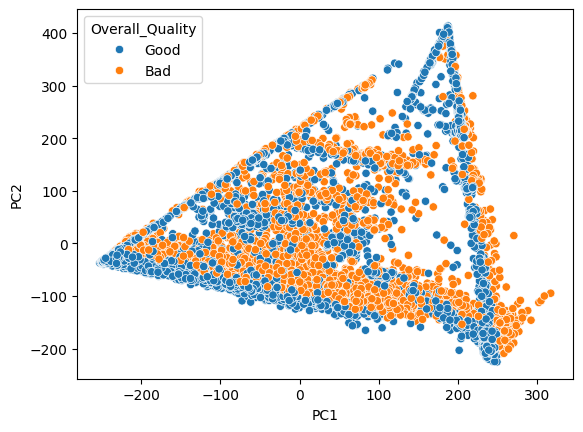

In [94]:
df['Good_Percentage'] = df.loc[:, 'Good_Days'] / df.loc[:, 'Days_with_AQI']
df['Overall_Quality'] = df['Good_Percentage'].apply(lambda x: 'Good' if x >= 0.80 else 'Bad')

# Overall quality is defined as (good_days / days_with_aqi) >= 0.80
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Overall_Quality')

Intepreting PCA plots is often difficult. We can see here that bad data points appear more in the range of PC1 > 250 and -50 < PC2 < 50.

Based on this graph, it's hard to give names to PC1 and PC2 because bad and good data points seem to blend into each other.


We can say that by reducing the dimension from 15 to 2, some information have been lost. Based on this graph, we can say that this type of analysis is not as beneficial as it would intially seem.